In [32]:
import sys
import os
import time

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    % cd / gdrive / My Drive / ANNDL-H1 /
    !pip install sklearn
    !pip install visualkeras

import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import keras_cv as keras_cv
import tensorflow_datasets as tfds

#OUR CUSTOM HELPER CLASS
sys.path.append('../../../Utils/')
from DatasetHelper import *
from ModelHelper import ModelHelper
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

ModuleNotFoundError: No module named 'cv2'

In [15]:

dataset_dir = '../../data'
training_dir = os.path.join(dataset_dir, '')

In [16]:
#Create Instances Of Utils Helper
seed = 5000
labels = {0: 'Species1', 1: 'Species2', 2: 'Species3', 3: 'Species4', 4: 'Species5', 5: 'Species6', 6: 'Species7',
          7: 'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../", seed, create_dirs=True)  #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper = ModelHelper("../../", labels)  #take in input local models folder and lables
model_helper.create_seed(tf, seed);

In [17]:
#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]

Extracting data from dataset at: ../../data
Found 3542 images belonging to 8 classes.


100%|██████████| 442/442 [00:18<00:00, 23.78it/s]


In [18]:
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train

In [19]:
Y_train = np.argmax(Y_train, axis=1)

In [20]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE


def to_dict(image, label):
    label = tf.one_hot(label, 8)
    return {"images": image, "labels": label}


def prepare_dataset(dataset):
    return (
        dataset.shuffle(10 * BATCH_SIZE)
        .map(to_dict, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
    )



In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

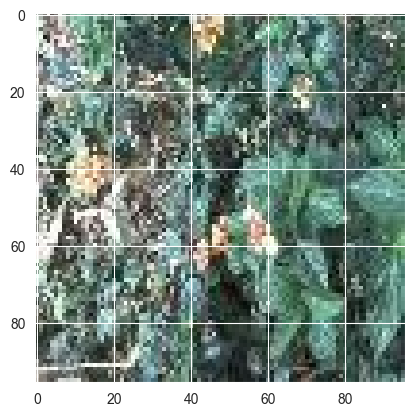

In [22]:
plt.imshow(X_train[0])

In [23]:
train_dataset = prepare_dataset(train_dataset)

In [24]:
train_dataset = train_dataset.map(keras_cv.layers.RandAugment(value_range=[0, 1]))

2022-11-20 13:51:13.746053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


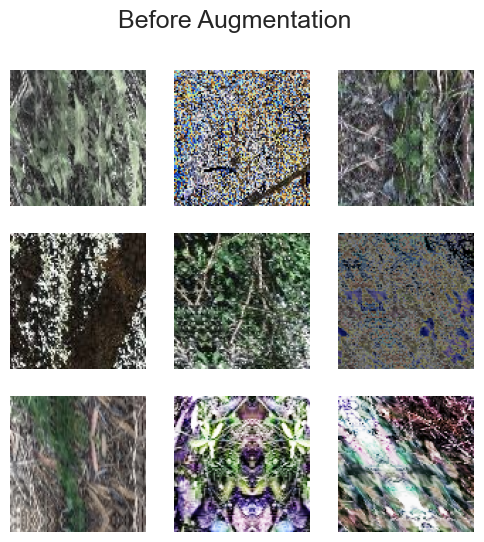

In [33]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.flip(images[0], axis=-1))
        plt.axis("off")
    plt.show()


visualize_dataset(train_dataset, title="Before Augmentation")

In [64]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.5,
)
train_dataset = load_dataset().map(rand_augment(train_dataset), num_parallel_calls=AUTOTUNE)

ValueError: Exception encountered when calling layer "rand_augment_21" "                 f"(type RandAugment).

Attempt to convert a value (<MapDataset element_spec=TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>) to a Tensor.

Call arguments received by layer "rand_augment_21" "                 f"(type RandAugment):
  • inputs=<MapDataset element_spec=TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None)>
  • training=True

In [72]:
def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )
    if split == "test":
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


dataset = prepare_dataset(train_dataset, "train")

TypeError: in user code:


    TypeError: tf__to_dict() missing 1 required positional argument: 'label'


In [71]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


visualize_dataset(train_dataset, "K")

2022-11-19 18:23:33.509693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:23:33.915818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:23:34.284105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 18:23:34.643119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} 2 root error(s) found.
  (0) INVALID_ARGUMENT: {{function_node __inference_Dataset_map_classkeras_cv.layers.preprocessing.rand_augment.RandAugment_57482}} indices[40,25] = 54484 is not in [0, 256)
	 [[{{function_node rand_augment_18_cond_1_random_choice_18_switch_case_indexed_case_equalization_18_map_while_cond_false_56210}}{{node rand_augment_18/cond_1/random_choice_18/switch_case/indexed_case/equalization_18/map/while/cond/GatherV2}}]]
	 [[rand_augment_18/cond_2/else/_28/rand_augment_18/cond_2/random_choice_18/switch_case/indexed_case_tfg_inlined_rand_augment_18/cond_2_1/pivot_9/_180/_147]]
  (1) INVALID_ARGUMENT: {{function_node __inference_Dataset_map_classkeras_cv.layers.preprocessing.rand_augment.RandAugment_57482}} indices[40,25] = 54484 is not in [0, 256)
	 [[{{function_node rand_augment_18_cond_1_random_choice_18_switch_case_indexed_case_equalization_18_map_while_cond_false_56210}}{{node rand_augment_18/cond_1/random_choice_18/switch_case/indexed_case/equalization_18/map/while/cond/GatherV2}}]]
0 successful operations.
0 derived errors ignored. [Op:IteratorGetNext]

<Figure size 600x600 with 0 Axes>